# DAGRegressor Tutorial

## Contents

This notebook walks through using the sklearn style DAGRegressor on a real dataset.

___
## Real Data (boston housing)

This section demonstrates the performance of the algorithm on a real-world dataset. The main things to note in this section are:
- The scale sensitivity of the algorithm
- Interpretability of nonlinear `.coef_`

The boston housing dataset is a classic benchmark regression task. The objective is to predict a set of house prices given a small set of features.

The meaning of the set of avaliable features is shown below.

In [47]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
print(load_boston(return_X_y=False)["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

#### Lets initially benchmark the performance of an `ElasticNetCV` fitted across the entire dataset.

In [48]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()


reg = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=True)

from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

MEAN R2: 0.700


### Linear DAGRegressor

The DAGRegressor has several parameters which can be used to better fit a more complicated noisy DAG:
- `alpha`: The l1 (lasso) regularisation parameter. Increasing this creates a sparser DAG.
- `beta`: The l2 (ridge) regularisation parameter.
It was decided to use `alpha` and `beta` rather than `alpha` and `l1_ratio` like in sklearn elasticnet to uncouple the parameters during optimisation.

There are several parameters which are also of interest which have good defaults, but we highlight here:
- `dependent_target`: This forces the target variable y to be only a child node. This is important for performance because in some cases `X -> y` is indistinguishable from `y -> X`. Enabling this (default enabled) ensures that the regressor performance at least matches linear regression. The trade-off is that the learned structure might be less accurate if y does cause other features.
- `enforce_dag`: This thresholds the learned structure model until the system is a DAG. This is useful for removing the small straggler connections which enables the DAG to be visualised easier. It does not impact performance, because the regressor still uses those connections under the hood.

MEAN R2: 0.706
CRIM       0.000000
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.310324
AGE        0.000000
DIS       -0.225455
RAD        0.000000
TAX        0.000000
PTRATIO    0.000000
B          0.000000
LSTAT     -0.372211
dtype: float64


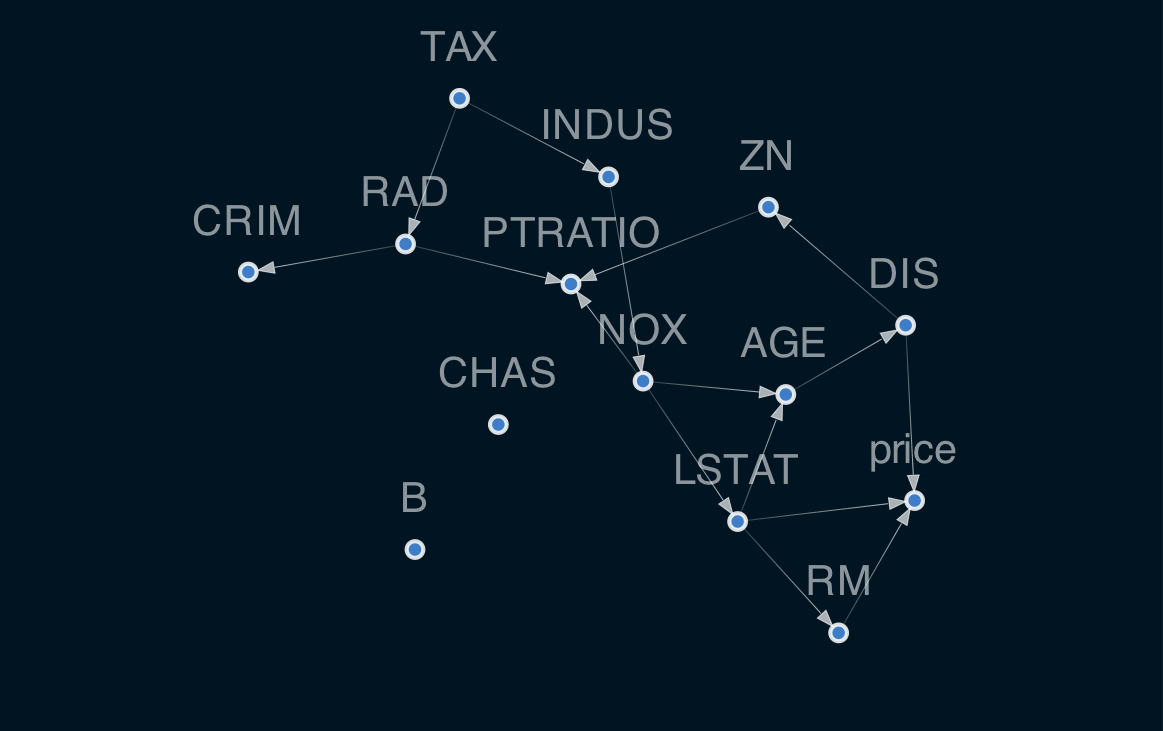

In [50]:
from causalnex.structure.sklearn import DAGRegressor
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = ss.fit_transform(X)
y = (y - y.mean()) / y.std()

reg = DAGRegressor(
                alpha=0.1,
                beta=0.9,
                fit_intercept=True,
                hidden_layer_units=None,
                dependent_target=True,
                enforce_dag=True,
                 )

from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X_pd = pd.DataFrame(X, columns=load_boston(return_X_y=False)["feature_names"])
y_pd = pd.Series(y, name="price")
reg.fit(X_pd, y_pd)
print(pd.Series(reg.coef_, index=load_boston(return_X_y=False)["feature_names"]))
reg.plot_dag(True)

### NonLinear DAGRegressor

Specifying a nonlinear model is extremely simple, only a single parameter needs to be altered: `hidden_layer_units`

`hidden_layer_units` takes _any_ **iterable** of **integers**: 
- The value specifies the number of perceptrons to use in each nonlinear MLP layer:
- The number of elements in the iterable determines the number of hidden layers. 
The more layers and more perceptrons per layer, the more complicated the function which can be fit. The trade off is a greater tendency to overfit, and slower fitting.

A good default starting argument is ~[5]. This is unlikely to overfit, and usually demonstrates immidiately whether the DAG has nonlinear components.

The setting of the `alpha` and `beta` parameters is very important.
Typically `beta` is more important than `alpha` when using nonlinear layers. This is because l2 is applied across all layers, whereas l1 is only applied to the first layer.
A good starting point is `~beta=0.5`.

**NOTE it is very important to scale your data!**

The nonlinear layers contain sigmoid nonlinearities which can become saturated with unscaled data. Also, unscaled data means that regularisation parameters do not impact weights across features equally.

For convnenience, setting `standardize=True` scales both the X and y data during fit. It also inverse transforms the y on predict similar to the sklearn `TransformedTargetRegressor`.

MEAN R2: 0.833


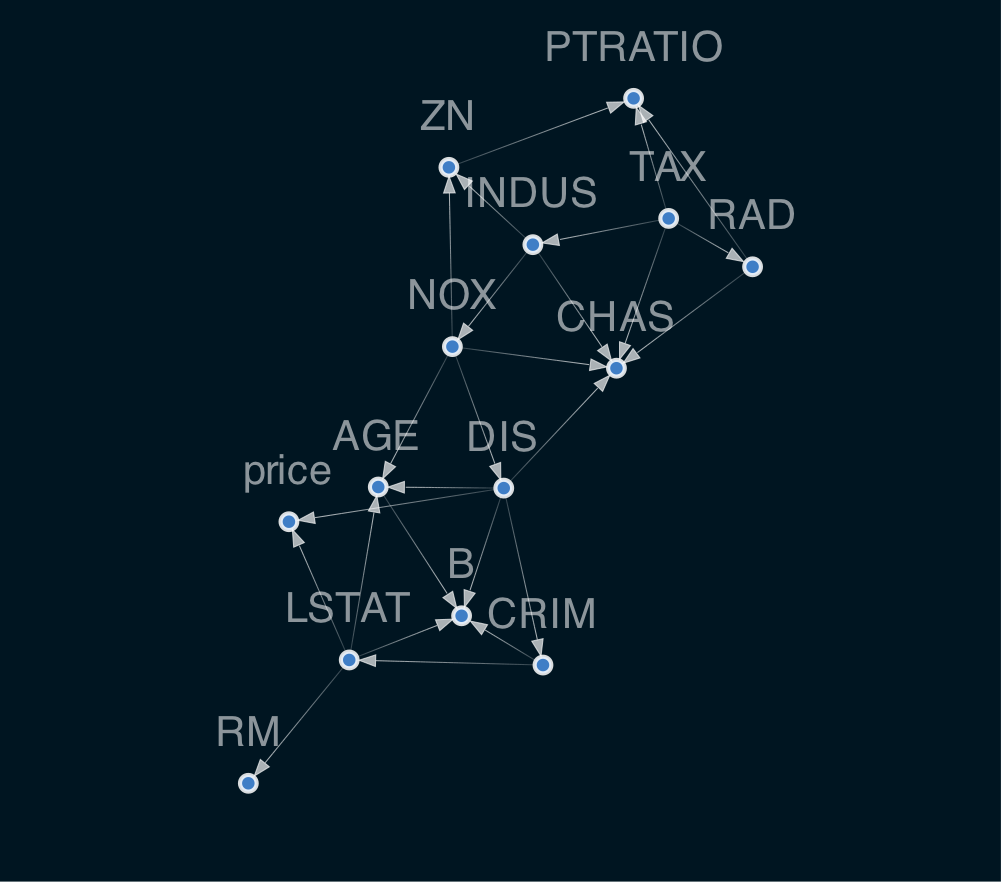

In [54]:
from causalnex.structure.sklearn import DAGRegressor
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

reg = DAGRegressor(threshold=0.0,
                    alpha=0.0,
                    beta=0.5,
                    fit_intercept=True,
                    hidden_layer_units=[5],
                    standardize=True,
                 )

from sklearn.model_selection import KFold
scores = cross_val_score(reg, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

X_pd = pd.DataFrame(X, columns=load_boston(return_X_y=False)["feature_names"])
y_pd = pd.Series(y, name="price")
reg.fit(X_pd, y_pd)

reg.plot_dag(True)

### Interpereting the Nonlinear DAG

For nonlinear analysis, understanding the impact of one feature on another is not as simple as taking the mean effect as in the linear case.
Instead, a combination of `reg.coef_` and `reg.feature_importances` should be used:

- `reg.coef_` provides the mean **directional** effect of all the features on the target. This gives average directional information, but can be misleading in terms of magnitude if the feature has a positive _and_ negative effect on the target.

- `reg.feature_importances_` provides the mean **magnitude** effect of the features on the target. These values will be _strictly larger_ than the `reg.coef_` because there are no cancellation effects due to sign differences. 

The magnitude difference between the `reg.coef_` and `reg.feature_importances_` values can give insight into the _degree of directional variability_ of the parameter:
- A large difference means that the parameter has **large positive and negative effects** on the target. 
- A zero difference means that the parameter always has the same directional impact on the target.

MEAN R2: 0.859
MEAN EFFECT DIRECTIONAL:
CRIM      -0.455048
ZN        -0.081971
INDUS      0.031664
CHAS       0.033811
NOX       -0.226108
RM         0.328084
AGE       -0.160502
DIS       -0.479593
RAD        0.265122
TAX       -0.230414
PTRATIO   -0.089173
B          0.098137
LSTAT     -0.344907
dtype: float64
MEAN EFFECT MAGNITUDE:
CRIM       0.455280
ZN         0.083515
INDUS      0.109172
CHAS       0.048846
NOX        0.226108
RM         0.364239
AGE        0.176076
DIS        0.479593
RAD        0.265122
TAX        0.238738
PTRATIO    0.118665
B          0.150867
LSTAT      0.347829
dtype: float64


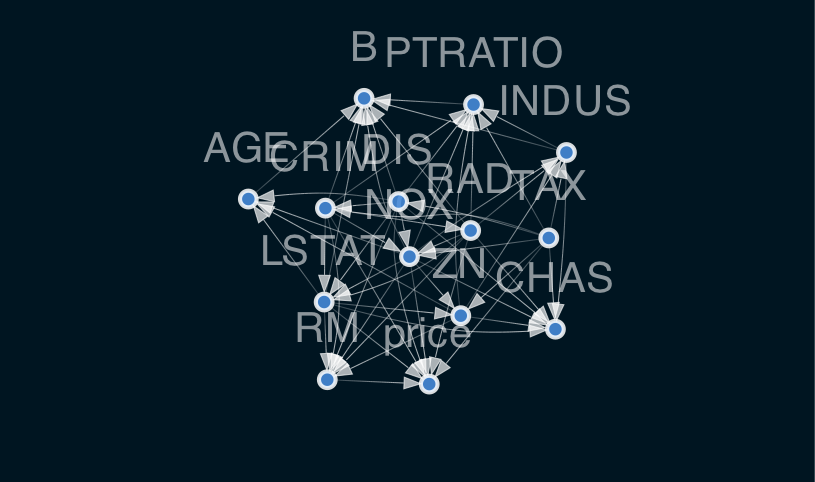

In [56]:
from causalnex.structure.sklearn import DAGRegressor
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

reg = DAGRegressor( alpha=0.0,
                    beta=1.0,
                    fit_intercept=True,
                    hidden_layer_units=[8, 8, 8],
                    standardize=True,
                 )

from sklearn.model_selection import KFold
scores = cross_val_score(reg, X_pd.values, y_pd.values, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

reg.fit(X_pd, y_pd)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=load_boston(return_X_y=False)["feature_names"]))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=load_boston(return_X_y=False)["feature_names"]))

reg.plot_dag(True)

The `reg.get_edges_to_node` method allows for analysis of other edges in the graph easily.

Passing in `data="weight"` returns the mean effect magnitude of the variables on the requested node. It is equivalent to the `reg.feature_importances` return for the target node.

Passing in `data="mean_effect"` returns the mean directional effect.

Below is a good example of a large difference between the magnitude and directional effects: 
- The feature RAD has overall a large effect on the presence of NOX. 
- However, the _directional_ effect of this feature is highly variable, which leads the mean_effect to be an order of magnitude smaller than the mean effect magnitude!

In [57]:
vals = reg.get_edges_to_node("NOX", data="weight").copy()
vals[vals.abs() < 0.01] = 0
vals

CRIM       0.663028
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.000000
AGE        0.000000
DIS        0.723618
RAD        0.429126
TAX        0.858995
PTRATIO    0.000000
B          0.000000
LSTAT      0.000000
dtype: float64

In [58]:
vals = reg.get_edges_to_node("NOX", data="mean_effect")
vals[vals.abs() < 0.01] = 0
vals

CRIM       0.644507
ZN         0.000000
INDUS      0.000000
CHAS       0.000000
NOX        0.000000
RM         0.000000
AGE        0.000000
DIS       -0.615096
RAD        0.063520
TAX       -0.746946
PTRATIO    0.000000
B          0.000000
LSTAT      0.000000
dtype: float64

### Dependent Target

Setting the `dependent_target=False` has an impact on performance as shown below, but can give better insight into the overall nonlinear structure of the data.

This is effectively the same as fitting causalnex on the data using from_pandas, but using the sklearn interface provides a set of useful convenience functions not present in the base causalnex implementation.

MEAN R2: 0.838
MEAN EFFECT DIRECTIONAL:
CRIM      -0.152426
ZN         0.006836
INDUS      0.024601
CHAS       0.030994
NOX       -0.182232
RM         0.273697
AGE       -0.071418
DIS       -0.296711
RAD        0.111622
TAX       -0.223531
PTRATIO   -0.151172
B          0.071595
LSTAT     -0.412829
dtype: float64
MEAN EFFECT MAGNITUDE:
CRIM       0.152426
ZN         0.006899
INDUS      0.053876
CHAS       0.048723
NOX        0.182232
RM         0.283586
AGE        0.089832
DIS        0.296711
RAD        0.123725
TAX        0.228080
PTRATIO    0.151172
B          0.071595
LSTAT      0.413056
dtype: float64


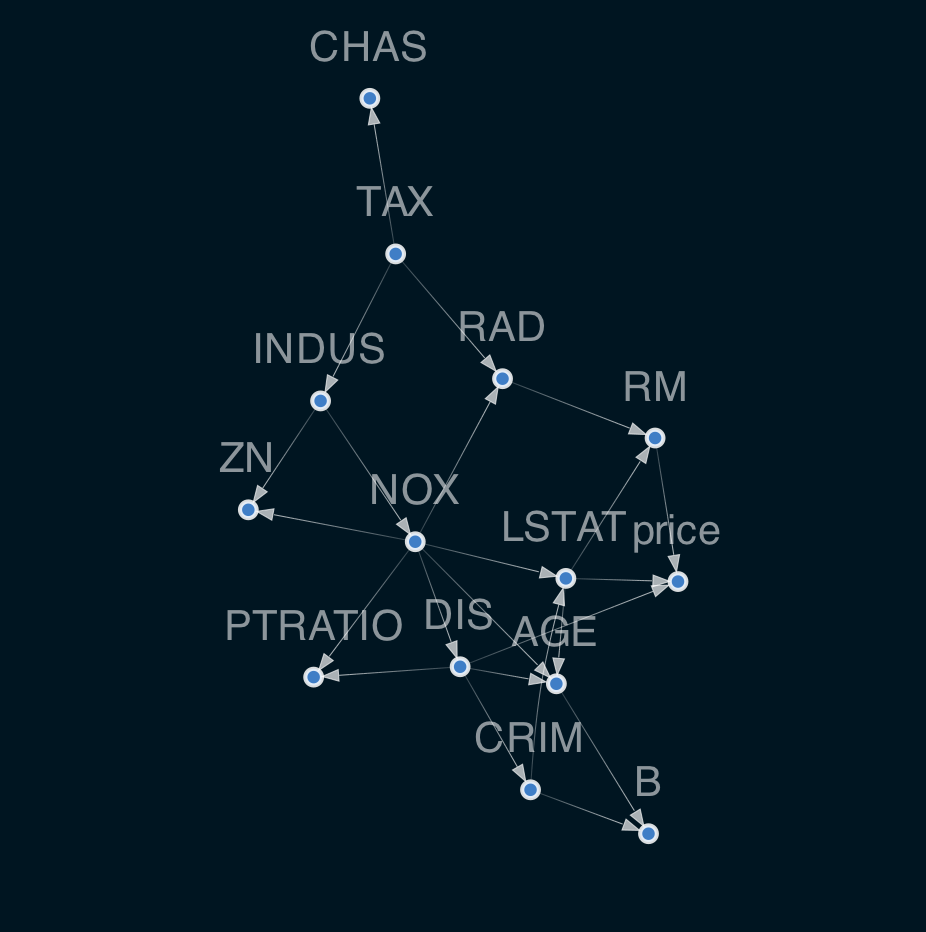

In [60]:
from causalnex.structure.sklearn import DAGRegressor
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)

reg = DAGRegressor( alpha=0.0,
                    beta=1.0,
                    fit_intercept=True,
                    hidden_layer_units=[5],
                    standardize=True,
                    dependent_target=True,
                 )

from sklearn.model_selection import KFold
scores = cross_val_score(reg, X_pd.values, y_pd.values, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN R2: {np.mean(scores).mean():.3f}')

reg.fit(X_pd, y_pd)
print("MEAN EFFECT DIRECTIONAL:")
print(pd.Series(reg.coef_, index=load_boston(return_X_y=False)["feature_names"]))
print("MEAN EFFECT MAGNITUDE:")
print(pd.Series(reg.feature_importances_, index=load_boston(return_X_y=False)["feature_names"]))

reg.plot_dag(True)